# Table of Contents
 <p><div class="lev1"><a href="#目的"><span class="toc-item-num">1&nbsp;&nbsp;</span>目的</a></div><div class="lev1"><a href="#準備"><span class="toc-item-num">2&nbsp;&nbsp;</span>準備</a></div><div class="lev1"><a href="#データのロード"><span class="toc-item-num">3&nbsp;&nbsp;</span>データのロード</a></div><div class="lev1"><a href="#モデルファイルのロード"><span class="toc-item-num">4&nbsp;&nbsp;</span>モデルファイルのロード</a></div><div class="lev1"><a href="#エンコード、デコード"><span class="toc-item-num">5&nbsp;&nbsp;</span>エンコード、デコード</a></div>

# 目的
* 学習済みのAEモデルを使って画像の再構成をする

# 準備

In [1]:
%matplotlib inline
import sys, os
import numpy as np
import pandas as pd
import six
import math

from PIL import Image
from StringIO import StringIO
import matplotlib.pyplot as plt

import chainer
from chainer import cuda, Function, gradient_check, Variable, optimizers, serializers, utils
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.functions.loss.vae import gaussian_kl_divergence

import tables

from model_VAE import VAE

In [2]:
def draw_img_rgb(data, size=128):
    n = data.shape[0]
    plt.figure(figsize=(n*2, 2))
    data /= data.max()
    cnt = 1
    for idx in np.arange(n):
        plt.subplot(1, n, cnt)
        tmp = data[idx,:,:,:].transpose(1,2,0)
        plt.imshow(tmp)
        plt.tick_params(labelbottom="off")
        plt.tick_params(labelleft="off")
        cnt+=1
    plt.show()

# データのロード

In [27]:
# パラメータ設定
#image_dir = "/home/tokita/projects/cinet/YouTubePriors_flv4/DividedImages/images_res-20160708"
#model_file = "./out/out_models_vae03/model_VAE_00500.h5"

image_dir_tr = "/home/tokita/projects/cinet/YouTubePriors_flv4/DividedImages/images_resize/flv_x_001"
image_dir_te = "/home/tokita/projects/cinet/YouTubePriors_flv4/DividedImages/images_resize/flv_x_024"
model_file = "./out/out_models_vae12/model_VAE_00100.h5"

n_latent = 3000
input_size = 96
input_ch = 3
output_ch = 512

In [5]:
# ## データのロード
fs = os.listdir(image_dir_tr)
ds_train = []
for fn in fs:
    f = open('%s/%s'%(image_dir_tr,fn), 'rb')
    img_bin = f.read()
    img = np.asarray(Image.open(StringIO(img_bin)).convert('RGB')).astype(np.float32).transpose(2, 0, 1)
    ds_train.append(img)
    f.close()
ds_train = np.asarray(ds_train)
# データ数
N = ds_train.shape[0]
N_train = N
# 正規化(0~1に)
ds_train /= 255
x_train = ds_train

fs = os.listdir(image_dir_te)
ds_test = []
for fn in fs:
    f = open('%s/%s'%(image_dir_te,fn), 'rb')
    img_bin = f.read()
    img = np.asarray(Image.open(StringIO(img_bin)).convert('RGB')).astype(np.float32).transpose(2, 0, 1)
    ds_test.append(img)
    f.close()
ds_test = np.asarray(ds_test)
# データ数
N_test = ds_test.shape[0]
# 正規化(0~1に)
ds_test /= 255
x_test = ds_test

print 'x_train.shape={}'.format(x_train.shape)
print 'x_test.shape={}'.format(x_test.shape)

N_train = x_train.shape[0]
N_test = x_test.shape[0]
print('N_train={}, N_test={}'.format(N_train, N_test))

x_train.shape=(40593, 3, 96, 96)
x_test.shape=(36057, 3, 96, 96)
N_train=40593, N_test=36057


In [ ]:
'''
# ## データのロード
fs = os.listdir(image_dir)
dataset = []
for fn in fs:
    f = open('%s/%s'%(image_dir,fn), 'rb')
    img_bin = f.read()
    img = np.asarray(Image.open(StringIO(img_bin)).convert('RGB')).astype(np.float32).transpose(2, 0, 1)
    dataset.append(img)
    f.close()
dataset = np.asarray(dataset)
# データ数
N = dataset.shape[0]
train_rate = 0.8
N_train = int(N*train_rate)
N_test = N - N_train
# 正規化(0~1に)
dataset /= 255
# 訓練データとテストデータに分割
x_train, x_test = np.split(dataset, [N_train])
print 'x_train.shape={}'.format(x_train.shape)
print 'x_test.shape={}'.format(x_test.shape)

N_train = x_train.shape[0]
N_test = x_test.shape[0]
print('N_train={}, N_test={}'.format(N_train, N_test))
'''

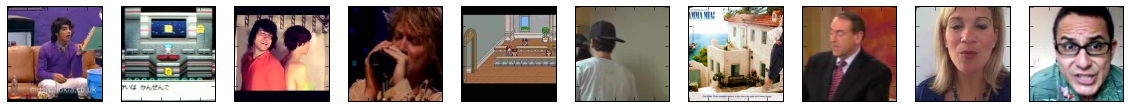

In [6]:
idx = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900]
draw_img_rgb( x_train[idx] )

# モデルファイルのロード

In [28]:
model = VAE(n_latent=n_latent, input_size=input_size, input_ch=input_ch, output_ch=output_ch)
serializers.load_hdf5(model_file, model)

# エンコード、デコード

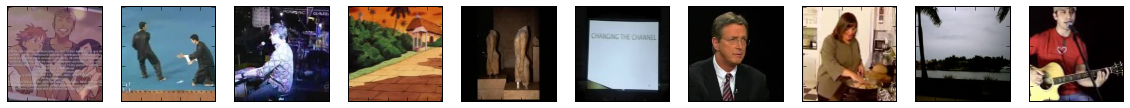

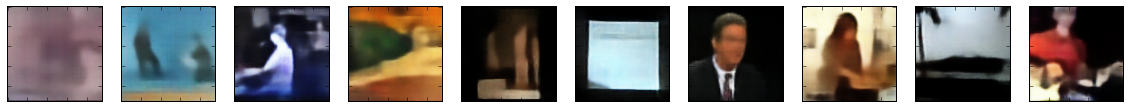

In [29]:
# 入力画像
test_ind = np.random.permutation(N_train)[:10]
test = chainer.Variable(np.asarray(x_train[test_ind]), volatile='on')
draw_img_rgb(test.data)

# 画像再構成
y = model(test)
draw_img_rgb(y.data)

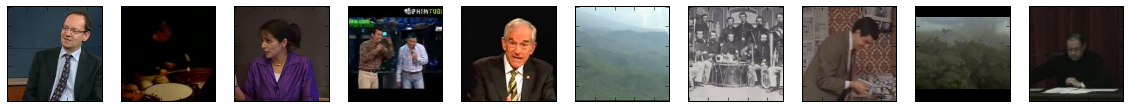

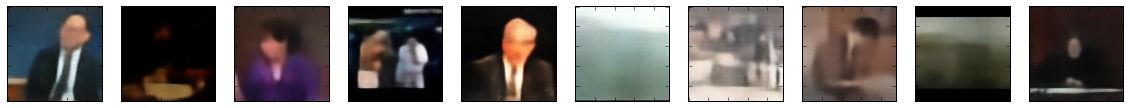

In [30]:
# 入力画像
test_ind = np.random.permutation(N_test)[:10]
test = chainer.Variable(np.asarray(x_test[test_ind]), volatile='on')
draw_img_rgb(test.data)

# 画像再構成
y = model(test)
draw_img_rgb(y.data)

Reconstruct Test [random input]


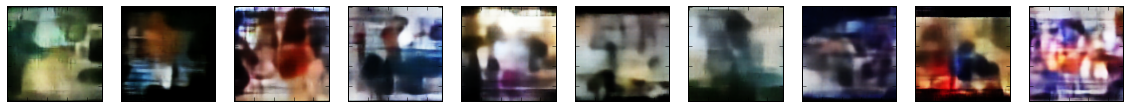

In [31]:
## draw images from randomly sampled z
z = chainer.Variable(np.random.normal(0, 1, (10, n_latent)).astype(np.float32))
x = model.decode(z)
print "Reconstruct Test [random input]"
draw_img_rgb(x.data)

# Table of Contents
 <p><div class="lev1"><a href="#目的"><span class="toc-item-num">1&nbsp;&nbsp;</span>目的</a></div><div class="lev1"><a href="#準備"><span class="toc-item-num">2&nbsp;&nbsp;</span>準備</a></div><div class="lev1"><a href="#データのロード"><span class="toc-item-num">3&nbsp;&nbsp;</span>データのロード</a></div><div class="lev1"><a href="#モデルファイルのロード"><span class="toc-item-num">4&nbsp;&nbsp;</span>モデルファイルのロード</a></div><div class="lev1"><a href="#エンコード、デコード"><span class="toc-item-num">5&nbsp;&nbsp;</span>エンコード、デコード</a></div><div class="lev2"><a href="#エンコード"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>エンコード</a></div><div class="lev2"><a href="#デコード"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>デコード</a></div>